01.02.2021

### Image Processing in Physics
#### Julia Herzen, Klaus Achterhold, Clemens Schmid. Manuel Schultheiss

# Tomographic Reconstruction I

This exercise will be about a very simplified implementation of tomographic
reconstruction, using filtered backprojection.

The exercise consists of three parts:
First, you will simulate the data aquisistion in computed tomography, by
calculating the sinogram from a given input sample slice.
Second, you will have to apply a ramp filter to this sinogram.
Third, you will implement a simple backprojection algorithm.

If you do not manage to do one part of the exercise you can still go on by
loading the provided .npy arrays 'sino_backup.npy' and
'filtered_sino_backup.npy'.

You need to replace the ??? in the code with the required commands.

In [18]:
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

%matplotlib notebook
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = "none"

    

In [24]:
def forwardproject(sample, angles):
    """
    Simulate data aquisition in tomography from line projections.
    Forwardproject a given input sample slice to obtain a simulated sinogram.

    Hints
    -----
    Use scipy.ndimage.rotate(..., reshape=False) to simulate the sample
    rotation.
    Use numpy.sum() along one axis to simulate the line projection integral.
    """
    sh = np.shape(sample)                # calculate shape of sample
    Nproj = len(angles)                  # calculate number of projections

    # define empty sinogram container, angles along y-axis
    sinogram = np.zeros((Nproj, sh[1]))

    # loop over all projections
    for proj in np.arange(Nproj):
        print("Simulating:     %03i/%03i" % (proj+1, Nproj), end="\r", flush=True)
        
        im_rot = nd.rotate(sample, angles[proj], reshape=False)
        sinogram[proj, :] = np.sum(im_rot, axis=0)
        
    return sinogram


def filter_ramlak(sinogram):
    """
    Filter a given sinogram using a ramp filter

    Hints:
    First define a ramp filter in Fourier domain (you can use np.fft.fftfreq).
    Filter the sinogram in Fourier space using the convolution theorem.
    """

    Nproj, Npix = np.shape(sinogram)

    # Generate basic ramp filter (hint: there is the function np.fft.fftfreq.
    # Try it and see what it does. Watch out for a possible fftshift)
    ramp_filter = np.abs(np.fft.fftfreq(Npix))

    # filter the sinogram in Fourier space in detector pixel direction
    # Use the np.fft.fft along the axis=1
    sino_ft = np.fft.fft(sinogram, axis=1)

    # Multiply the ramp filter onto the 1D-FT of the sinogram and transform it
    # back into spatial domain
    sino_filtered = np.real(np.fft.ifft(sino_ft * ramp_filter, axis=1))

    return sino_filtered




def backproject(sinogram, angles):
    """
    Backproject a given sinogram.
    
    Hints:
    Perform the backprojection inversely to the way we did the
    forwardprojection, by smearing each projection in the sinogram back along
    the axis that you summed before in forwardproject(),
    then rotating the resulting backprojection
    to get the right backprojection angle.
    
    Use scipy.ndimage.rotate(..., ..., reshape=False)
    """
    
    # define empty container for reconstruction of sample
    Nproj, Npix = np.shape(sinogram)
    reconstruction = np.zeros((Npix, Npix))

    # loop over all projections
    for proj in np.arange(Nproj): 
        print("Reconstructing: %03i/%i" % (proj+1, Nproj), end="\r", flush=True)

        backprojection = np.tile(sinogram[proj, :], (Npix, 1))
        backprojection /= Npix  # Just normalization
        rotated_backprojection = nd.rotate(backprojection, -angles[proj], reshape=False)

        # Add the rotated backprojection
        reconstruction += rotated_backprojection

    return reconstruction


## Part 1: Forward and Backprojection

Read in sample data of a human head. In reality, this data is unknown and what you are
looking for when performing a CT scan.

In [20]:
sample = plt.imread('Head_CT_scan.jpg')

Define array containing the projection angles.

In [21]:
Nangles = 301
angles = np.linspace(0, 360, Nangles, False) 

Simulate the process of tomographic data acquisition by line projections.

<IPython.core.display.Javascript object>


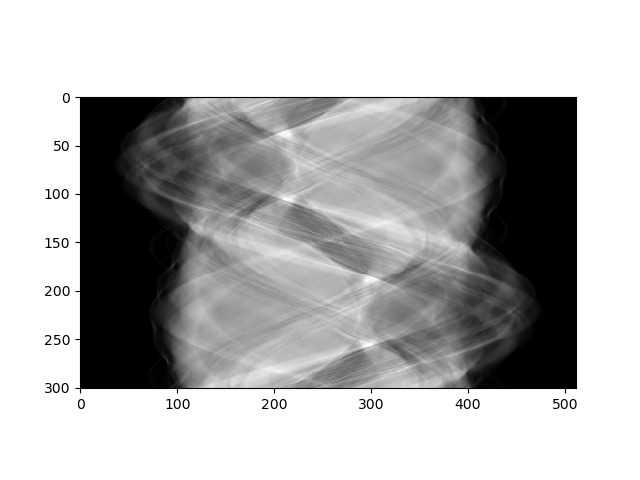

In [22]:
sino = forwardproject(sample, angles)

# use this line if you do not manage the forward projection
# sino = np.load('sino_backup.npy')

plt.figure()
plt.imshow(sino)

<IPython.core.display.Javascript object>


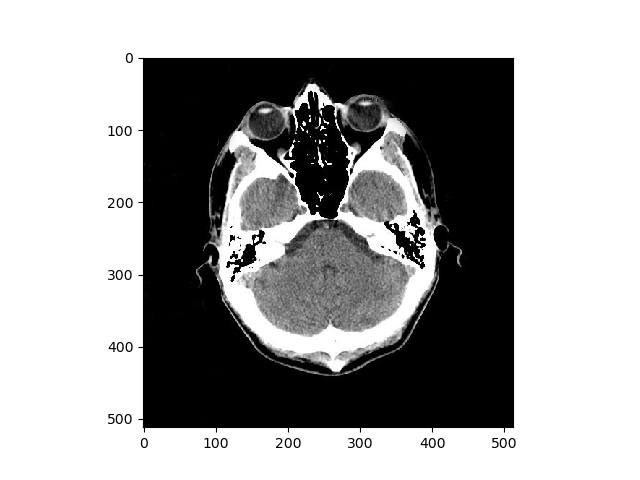

In [23]:
plt.figure()
plt.imshow(sample)

Perform the filtered backprojection by 

1. Filtering the projections
2. Performing backprojection with the filtered projections

In [7]:
# filter the sinogram with the ramp filter (or some other filter)
filtered_sino = filter_ramlak(sino)

# use this line if you do not manage the filtering
# filtered_sino = np.load('filtered_sino_backup.npy')

# backprojection
reco = backproject(filtered_sino, angles)

<IPython.core.display.Javascript object>


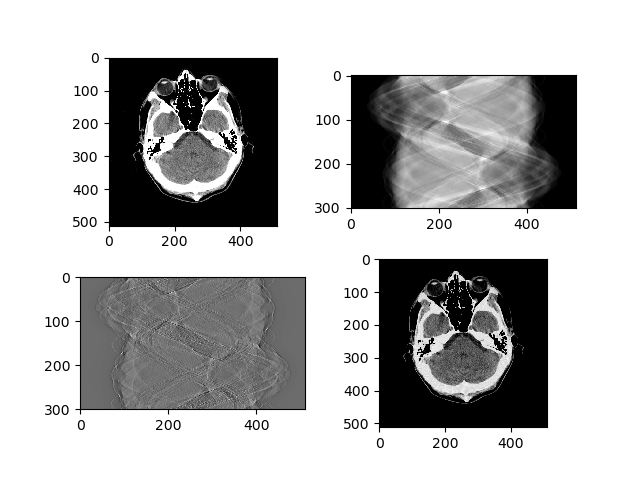

In [8]:
plt.figure()
plt.subplot(221)
plt.imshow(sample)
plt.subplot(222)
plt.imshow(sino)
plt.subplot(223)
plt.imshow(filtered_sino)
plt.subplot(224)
plt.imshow(reco, vmin=0.)

## Part 2: Image Artifacts

We simulate various kinds of artifacts on the projections and evaluate the result in the reconstruction.

### Artifact 1 - Hot / Dead Pixel

Single pixels on detector may not respond to x-rays. 

They appear as completely bright ("hot") or dark ("dead"), independent of the measurement. Because of the projection filter effectively being a spatial derivative (look at [Fourier transform identities](https://en.wikipedia.org/wiki/Fourier_transform#Functional_relationships,_one-dimensional)), a single broken pixel has a large effect on the reconstruction.

Set one pixel in the sinogram to 0 for all angles and see how the reconstruction changes.

<IPython.core.display.Javascript object>


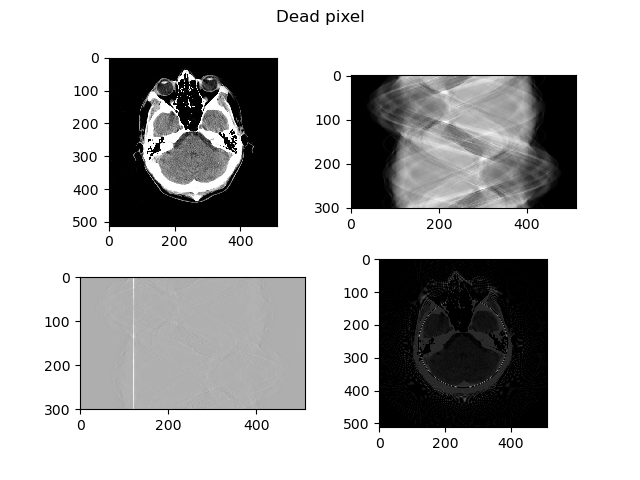

In [9]:
Nangles = 301
angles = np.linspace(0, 360, Nangles, False)

sino = forwardproject(sample, angles)

# simulate a dead pixel in the detector line
sino[:, 120] = 0

# filter the sinogram with the ramp filter and reconstruct it
filtered_sino = filter_ramlak(sino)
reco = backproject(filtered_sino, angles)

plt.figure()
plt.suptitle('Dead pixel')
plt.subplot(221)
plt.imshow(sample)
plt.subplot(222)
plt.imshow(sino)
plt.subplot(223)
plt.imshow(filtered_sino)
plt.subplot(224)
plt.imshow(reco, vmin=sample.min(), vmax=sample.max())

### Artifact 2 - Center shift

Intrinsically, tomography assumes that the rotation axis is in the center of
each projection. If this is not the case, each projection is shifted left or
right with respect to the optical axis. This is called center shift.

In principle each projection can have its own center shift. Here we simulate the same centershift on all projections, which causes blurring in the reconstruction.

<IPython.core.display.Javascript object>


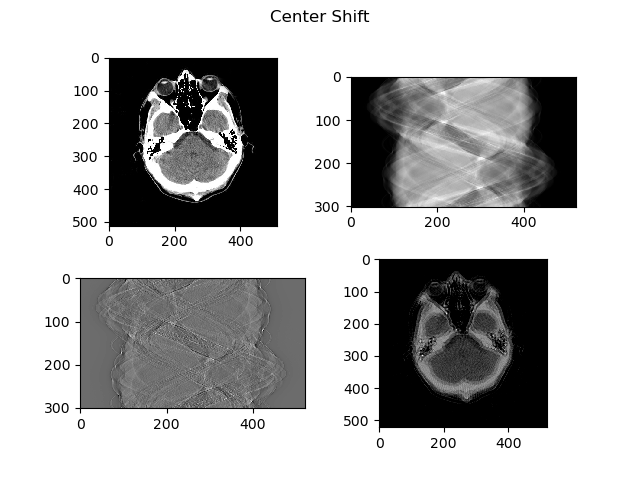

In [10]:
Nangles = 301
angles = np.linspace(0, 360, Nangles, False)

sino = forwardproject(sample, angles)

# shift the sinogram by a few pixels (~2) or pad the detector either to the
# left or right side with 0's.
sino = np.concatenate((sino, np.zeros((Nangles, 10))), axis=1)

# filter the sinogram with the ramp filter and reconstruct it
filtered_sino = filter_ramlak(sino)
reco = backproject(filtered_sino, angles)

plt.figure()
plt.suptitle('Center Shift')
plt.subplot(221)
plt.imshow(sample)
plt.subplot(222)
plt.imshow(sino)
plt.subplot(223)
plt.imshow(filtered_sino)
plt.subplot(224)
plt.imshow(reco, vmin=0)

## Artifact 3 - Few angles / undersampling

When using fewer projections than usual, the image quality decreases. 

From the Nyquist limit, we need at least $N_x \cdot \frac{\pi}{2}$ projection angles, with $N_x$ being the number of pixels on the projections in x direction. If the number of angles is smaller, we see undersampling artifacts in the reconstruction in the form of radial lines.

<IPython.core.display.Javascript object>


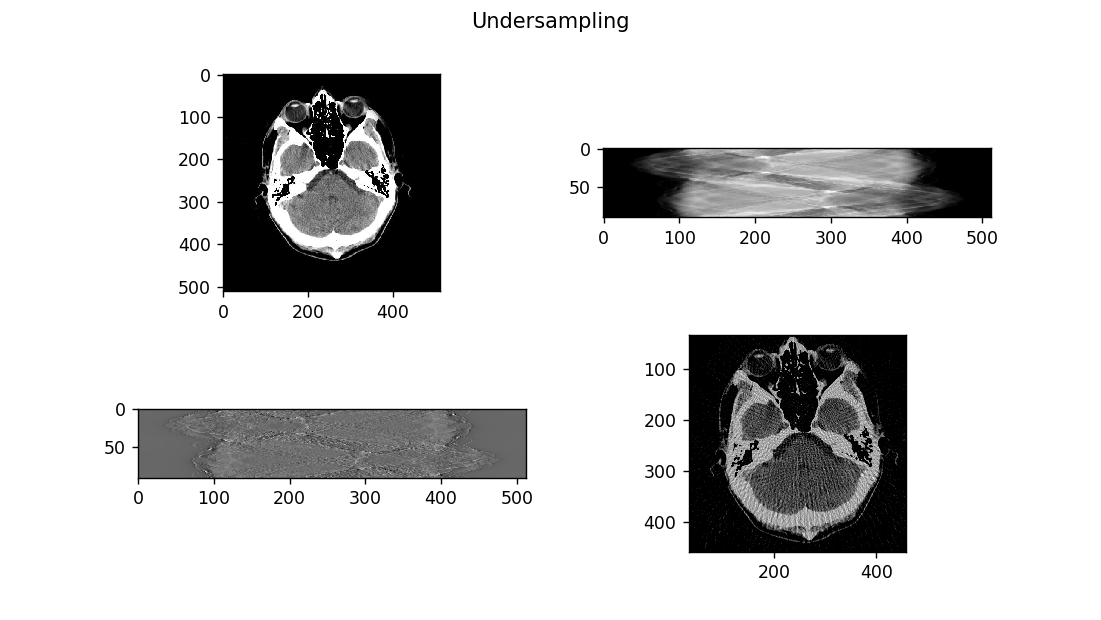

In [14]:
Nangles = 91
angles = np.linspace(0, 360, Nangles, False)

sino = forwardproject(sample, angles)

# filter the sinogram with the ramp filter and reconstruct it
filtered_sino = filter_ramlak(sino)
reco = backproject(filtered_sino, angles)

plt.figure()
plt.suptitle('Undersampling')
plt.subplot(221)
plt.imshow(sample)
plt.subplot(222)
plt.imshow(sino)
plt.subplot(223)
plt.imshow(filtered_sino)
plt.subplot(224)
plt.imshow(reco, vmin=0.)

## Artifact 4 - Missing projections to tomosynthese

Another angular sampling problem is the angular sampling not being distributed over the full $360^\circ$. Colloquially this means we are missing some angle wedge completely. Deploying a naive filtered backprojection results in artifacts in the reconstruction.

Replace the first 100 projections with zeros to emulate missing angles.

<IPython.core.display.Javascript object>


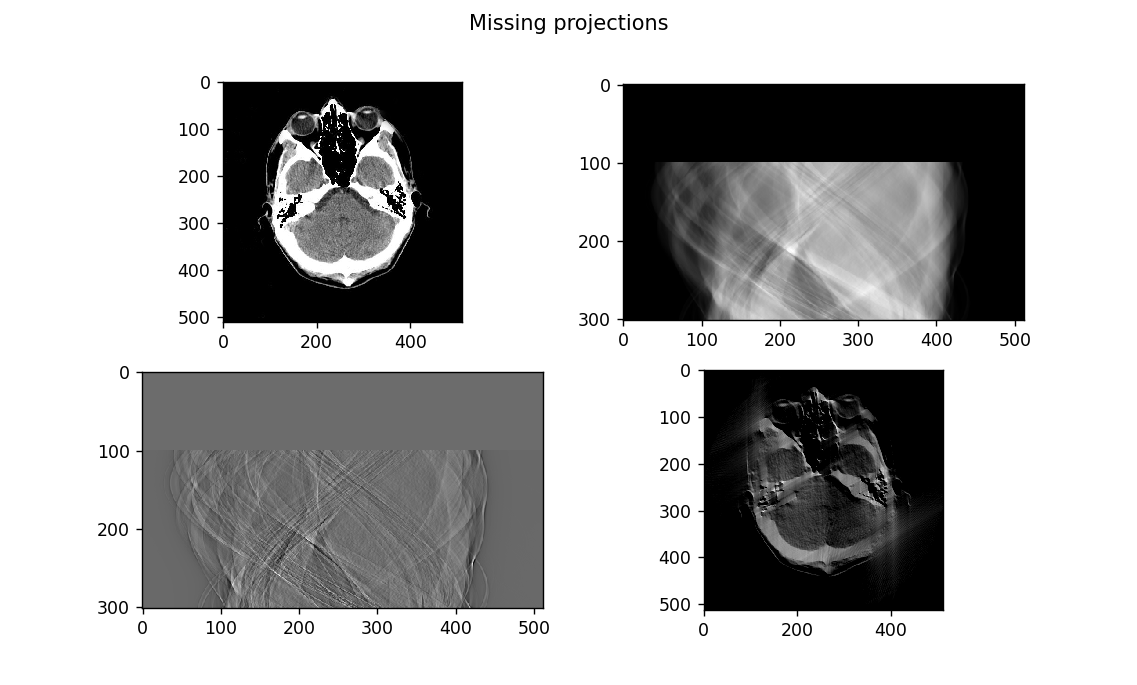

In [16]:
Nangles = 301
angles = np.linspace(0, 180, Nangles, False)

sino = forwardproject(sample, angles)

# simulate one or more missing projections (e.g. replace with zeros) up to a
# missing projection wedge
sino[:100] = 0

# filter the sinogram with the ramp filter and reconstruct it
filtered_sino = filter_ramlak(sino)
reco = backproject(filtered_sino, angles)

plt.figure()
plt.suptitle('Missing projections')
plt.subplot(221)
plt.imshow(sample)
plt.subplot(222)
plt.imshow(sino)
plt.subplot(223)
plt.imshow(filtered_sino)
plt.subplot(224)
plt.imshow(reco, vmin=0.)

## Artifact 5 - Noise

The conventional filtered backprojection assumes noise-free projections and is analytically exact in that case. For a real detector in finite scan time, we will always see some degree of statistical noise. 

Add some Gaussian, white noise to the projections/sinogram.

<IPython.core.display.Javascript object>


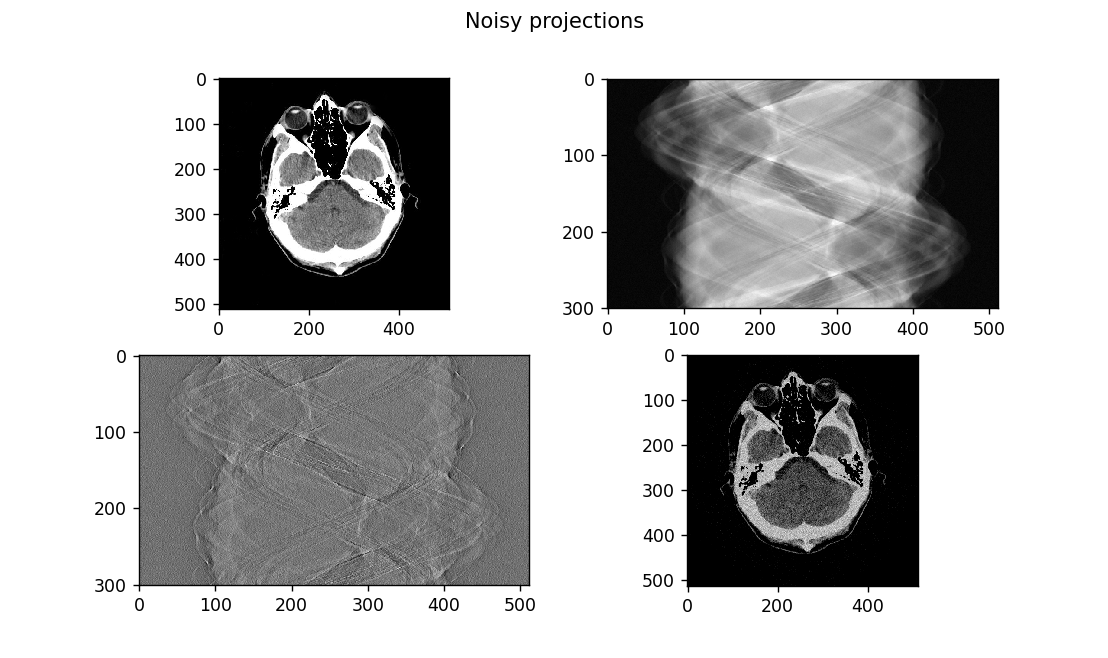

In [17]:
Nangles = 301
angles = np.linspace(0, 360, Nangles, False)

sino = forwardproject(sample, angles)

# simulate noise
sino += np.random.normal(0, 500, sino.shape)

# filter the sinogram with the ramp filter and reconstruct it
filtered_sino = filter_ramlak(sino)
reco = backproject(filtered_sino, angles)

plt.figure()
plt.suptitle('Noisy projections')
plt.subplot(221)
plt.imshow(sample)
plt.subplot(222)
plt.imshow(sino)
plt.subplot(223)
plt.imshow(filtered_sino)
plt.subplot(224)
plt.imshow(reco, vmin=0)